# DelftaCalculator basics and $\Delta$-learning vs. direct learning 

In [1]:
import os
import glob
from openbabel.pybel import readfile, readstring
import numpy as np
from delfta.utils import TESTS_PATH

Next, we read a few example molecules from SDFs (structure data files) from the QMugs dataset. For more details on how to input your own molecules, see the documentation of the Pybel API [here](https://open-babel.readthedocs.io/en/latest/UseTheLibrary/Python_PybelAPI.html).

In [2]:
mol_files = glob.glob(os.path.join(TESTS_PATH, "mols_working", "CHEMBL*.sdf"))
mols = [next(readfile("sdf", mol_file)) for mol_file in mol_files]

We'll initialize a calculator by stating which tasks we want to perform. Options are `all` (the default), `E_form`, `E_homo`, `E_lumo`, `E_gap`, `dipole`, and `charges`. You can also choose between `delta=True` (run a GNF2-xTB calculation and predict a delta correction to obtain an approximation of the DFT-value ($\omega$B97X-D/def2-SVP)) or `delta=False` (predict the DFT-value directly from the molecular structure).

In [3]:
from delfta.calculator import DelftaCalculator

calc_delta = DelftaCalculator(tasks=["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges", "wbo"], delta=True) 
# Verbose passing of arguments. We could've used "all" as well
predictions_delta = calc_delta.predict(mols, batch_size=32) # lower the batch size if you run into memory issues
calc_direct = DelftaCalculator(delta=False) 
# the default setting (tasks=None) means the calculator will perform all calculations for all endpoints
predictions_direct = calc_direct.predict(mols)

2021/08/17 11:08:22 AM | DelFTa | INFO: Now running xTB...
100%|██████████| 100/100 [00:19<00:00,  5.00it/s]
2021/08/17 11:08:42 AM | DelFTa | INFO: Now running network for model multitask_delta...
100%|██████████| 100/100 [00:00<00:00, 127.97it/s]
2021/08/17 11:08:44 AM | DelFTa | INFO: Now running network for model single_energy_delta...
100%|██████████| 100/100 [00:00<00:00, 148.98it/s]
2021/08/17 11:08:45 AM | DelFTa | INFO: Now running network for model wbo_delta...
100%|██████████| 100/100 [00:00<00:00, 2003.80it/s]
2021/08/17 11:08:45 AM | DelFTa | INFO: Now running network for model charges_delta...
100%|██████████| 100/100 [00:00<00:00, 134.88it/s]
2021/08/17 11:08:46 AM | DelFTa | INFO: Now running network for model wbo_direct...
100%|██████████| 100/100 [00:00<00:00, 1923.15it/s]
2021/08/17 11:08:46 AM | DelFTa | INFO: Now running network for model single_energy_direct...
100%|██████████| 100/100 [00:00<00:00, 148.84it/s]
2021/08/17 11:08:47 AM | DelFTa | INFO: Now running n

Let's put the output in a dataframe to get an overview: 

In [4]:
import pandas as pd

df = pd.DataFrame(predictions_delta)
df.insert(0, "structure", [os.path.basename(mol_file) for mol_file in mol_files])
df.rename(columns={"E_form": "E_form [Ha]", "E_homo": "E_homo [Ha]", "E_lumo": "E_lumo [Ha]", "E_gap": "E_gap [Ha]", "dipole": "dipole [D]", "charges": "charges [e]"})

,structure,E_homo [Ha],E_lumo [Ha],E_gap [Ha],dipole [D],E_form [Ha],wbo,charges [e]
0,CHEMBL4289810_conf_02.sdf,-0.302064,0.006121,0.308173,13.108984,-13.386251,"[1.0472561434080945, 1.4355962625626917, 1.463...","[0.039106887771492, -0.11877734663557053, -0.0..."
1,CHEMBL3903980_conf_00.sdf,-0.310683,-0.017756,0.293136,9.548662,-9.283680,"[2.14058521393149, 0.9786365274825386, 1.01255...","[-0.2594015128986359, 0.1006283691051102, 0.14..."
2,CHEMBL2435942_conf_01.sdf,-0.323205,0.004877,0.328053,6.078884,-10.162407,"[2.0548434207879276, 1.0847554978506595, 1.570...","[-0.2688738239357376, 0.2661211600165081, -0.2..."
3,CHEMBL3912963_conf_01.sdf,-0.263358,0.037992,0.301472,3.142913,-11.172449,"[1.098299138880292, 1.0990767196503997, 1.0793...","[0.08680130232685089, -0.4301411877746582, 0.0..."
4,CHEMBL2348937_conf_01.sdf,-0.288920,-0.013506,0.275500,5.306864,-5.816537,"[1.0749800410193728, 1.3833965678556162, 2.233...","[0.1251758496212387, -0.327358169425621, 0.250..."
...,...,...,...,...,...,...,...,...
95,CHEMBL3917059_conf_01.sdf,-0.273494,0.009785,0.283435,10.684330,-10.936253,"[1.0419491870467699, 1.4317017724599883, 1.207...","[0.05400450322792054, -0.1176872677693367, -0...."
96,CHEMBL227326_conf_00.sdf,-0.286335,0.027422,0.313738,2.580147,-9.605368,"[1.0697478938360678, 1.7635457660642426, 1.312...","[0.07681907703277588, -0.13869263451251984, -0..."
97,CHEMBL1083965_conf_00.sdf,-0.282955,0.000536,0.283635,2.869386,-6.422808,"[1.054163867286605, 1.589490061860834, 1.12354...","[0.09764020045684814, -0.10951772352624893, -0..."
98,CHEMBL209490_conf_02.sdf,-0.300207,0.033064,0.333306,3.550677,-9.241843,"[1.1219492652860066, 2.8124831715131555, 1.091...","[0.04482159704925537, -0.20360343209739684, -0..."


Get the DFT-calculated values from the QMugs SDFs and prepare everything for plotting:

In [5]:
predictions_delta["charges"] = np.concatenate(predictions_delta["charges"])
predictions_direct["charges"] = np.concatenate(predictions_direct["charges"])
predictions_delta["wbo"] = np.concatenate(predictions_delta["wbo"])
predictions_direct["wbo"] = np.concatenate(predictions_direct["wbo"])
dft_keys = ["DFT:FORMATION_ENERGY", "DFT:HOMO_ENERGY", "DFT:LUMO_ENERGY", "DFT:HOMO_LUMO_GAP", "DFT:DIPOLE", "DFT:MULLIKEN_CHARGES", "DFT:WIBERG_LOWDIN_BOND_ORDER"]
dft_values = {}
for dft_key in dft_keys:
    if dft_key == "DFT:DIPOLE": 
        dft_values[dft_key] =  [float(mol.data[dft_key].split("|")[-1]) for mol in mols]
    elif dft_key == "DFT:MULLIKEN_CHARGES" or dft_key == "DFT:WIBERG_LOWDIN_BOND_ORDER": 
        dft_values[dft_key] = [float(elem) for mol in mols for elem in mol.data[dft_key].split("|")]
    else:
        dft_values[dft_key] = [float(mol.data[dft_key]) for mol in mols]



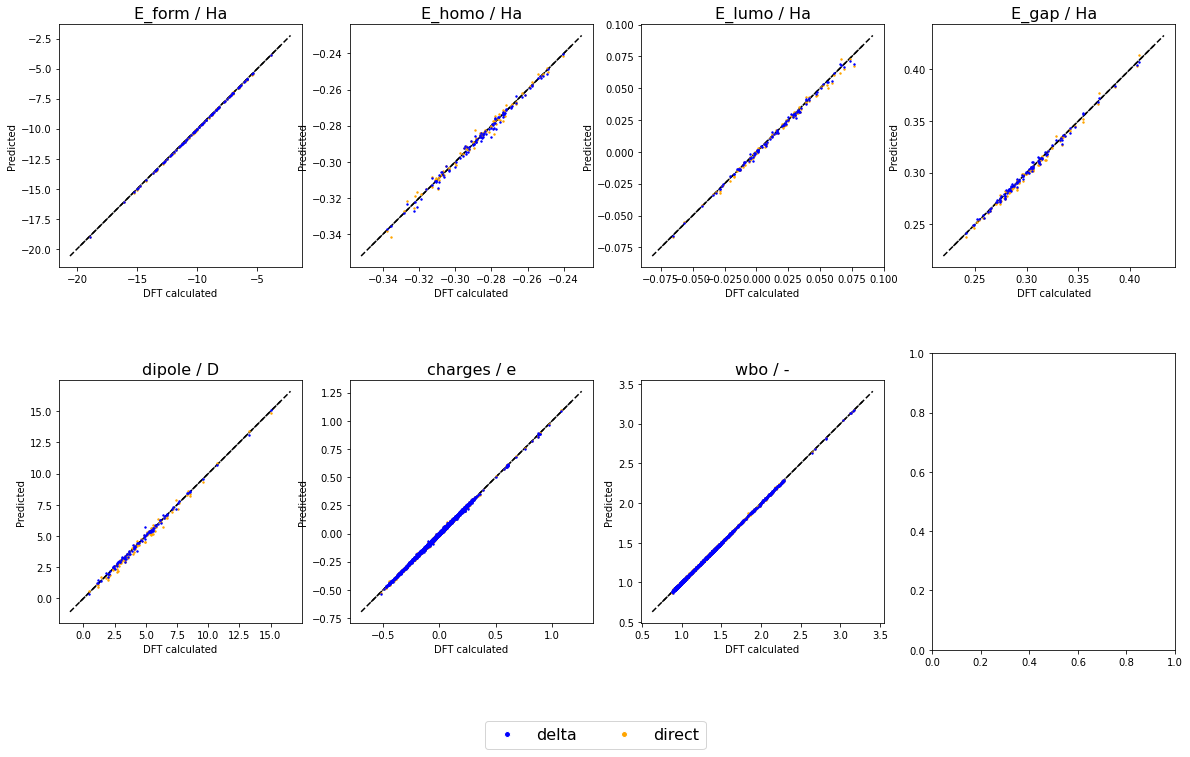

In [8]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

def make_plot(ax, dft_vals, pred_vals, label, unit, color): 
    ax.scatter(dft_vals, pred_vals, color=color, s=2)
    ax.set_xlabel("DFT calculated")
    ax.set_ylabel("Predicted")
    min_val = [min(ax.get_ylim()[0], ax.get_xlim()[0])]
    max_val = [max(ax.get_ylim()[1], ax.get_xlim()[1])]
    ax.plot([min_val, max_val], [min_val, max_val], '--', color="black", zorder=-1)
    ax.set_aspect("equal", "box")

fig = plt.figure(figsize=(20, 12))
gs = GridSpec(nrows=2, ncols=4)
pred_keys = ["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges", "wbo"]
all_dft_vals = [dft_values[dft_key] for dft_key in dft_keys]
all_pred_vals_delta = [predictions_delta[pred_key] for pred_key in pred_keys]
all_pred_vals_direct = [predictions_direct[pred_key] for pred_key in pred_keys]
units = ["Ha", "Ha", "Ha", "Ha", "D", "e", "-"]
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(4)]
for ax, pred_key, dft_key, unit in zip(axes, pred_keys, dft_keys, units): 
    make_plot(ax, dft_values[dft_key], predictions_direct[pred_key], pred_key, unit, "orange")
    make_plot(ax, dft_values[dft_key], predictions_delta[pred_key], pred_key, unit, "blue")
    ax.title.set_text(f"{pred_key} / {unit}")
    ax.title.set_fontsize(16)

handles = [Line2D([0], [0], marker='o', color="white", markerfacecolor="blue"), Line2D([0], [0], marker='o', color="white", markerfacecolor="orange")]
fig.legend(handles, ["delta", "direct"], fontsize=16, loc="lower center", ncol=2)

As you can see, both $\Delta$- and direct-learning approximate the $\omega$B97X-D/def2-SVP ground truth well. Check our paper for a more detailed discussion.

You can also create molecules directly from SMILES. In that case, you need to keep `force3D=True` (the default), so that the Pybel generates a three-dimensional structure for the molecule using the MMFF94 force field. Alternatively, you can create three-dimensional coordinates in some other way and feed the molecule to the calculator afterwards.

In [9]:
mols = [readstring("smi", "O=C(C)Oc1ccccc1C(=O)O")] # aspirin
calc = DelftaCalculator(delta=True, force3d=True)
preds_delta = calc.predict(mols)
print(preds_delta)

2021/08/17 11:11:49 AM | DelFTa | INFO: Assigned MMFF94 coordinates and added hydrogens to molecules at position(s) [0]
2021/08/17 11:11:49 AM | DelFTa | INFO: Now running xTB...
100%|██████████| 1/1 [00:00<00:00, 14.77it/s]
2021/08/17 11:11:49 AM | DelFTa | INFO: Now running network for model multitask_delta...
100%|██████████| 1/1 [00:00<00:00, 136.21it/s]
2021/08/17 11:11:49 AM | DelFTa | INFO: Now running network for model single_energy_delta...
100%|██████████| 1/1 [00:00<00:00, 148.29it/s]
2021/08/17 11:11:49 AM | DelFTa | INFO: Now running network for model wbo_delta...
100%|██████████| 1/1 [00:00<00:00, 162.17it/s]
2021/08/17 11:11:49 AM | DelFTa | INFO: Now running network for model charges_delta...
100%|██████████| 1/1 [00:00<00:00, 152.67it/s]

{'E_homo': array([-0.34509677], dtype=float32), 'E_lumo': array([-0.01114088], dtype=float32), 'E_gap': array([0.33391562], dtype=float32), 'dipole': array([3.6990473], dtype=float32), 'E_form': array([-3.869888], dtype=float32), 'wbo': [array([2.21595582, 1.06173968, 1.24060149, 1.15906834, 1.41167569,
       1.47586515, 1.46472365, 1.48213712, 1.39297546, 1.36727805,
       1.03598244, 2.1410789 , 1.37337249, 0.92433262, 0.93443387,
       0.95675455, 0.91939312, 0.92176247, 0.92425143, 0.91702898,
       1.07788977])], 'charges': [array([-0.19701141,  0.18012121, -0.09179312, -0.2915472 ,  0.20728303,
       -0.04023164,  0.01247798, -0.00152198, -0.01100367, -0.10213246,
        0.19624794, -0.22948795, -0.19206475,  0.06875254,  0.08437661,
        0.07215293,  0.03233329,  0.03540099,  0.02956946,  0.04266918,
        0.21610339])]}
